In [1]:
import pandas as pd
# Load the Sentiment140 dataset as a data frame
df = pd.read_csv('training.1600000.processed.noemoticon.csv', encoding = 'latin1', names=['polarity', 'id', 'date', 'query', 'user', 'text'])
# Print the first 5 rows of the data frame
print(f"\n The shape data is:{df.shape}")


 The shape data is:(1600000, 6)


In [2]:
data = df.copy()
data = data.sample(frac=1)

In [3]:
from pandas.api.types import is_numeric_dtype, is_string_dtype

for col_name in data.columns:
    if is_numeric_dtype(data[col_name]):
        data[col_name] = data[col_name].fillna(0)
    elif is_string_dtype(data[col_name]):
        data[col_name] = data[col_name].fillna('')
data.head()

,polarity,id,date,query,user,text
828402,4,1557017109,Sun Apr 19 01:32:57 PDT 2009,NO_QUERY,TechFalcon,I feel like today ended on a high note.
1456375,4,2063490626,Sun Jun 07 02:52:25 PDT 2009,NO_QUERY,meganmansfield,just heard busted on radio 1! yehhhh year 300...
64926,0,1689008588,Sun May 03 12:24:55 PDT 2009,NO_QUERY,ShelbyNicholeH,Ugh i really dont wanna leave florida its bea...
1234685,4,1992437732,Mon Jun 01 08:45:10 PDT 2009,NO_QUERY,Cathyroxx,Im so ! I just finished my twilight book !! N...
57362,0,1685648189,Sun May 03 01:22:15 PDT 2009,NO_QUERY,baihaikang,im bored doing homework?


In [4]:
def clean_text(x):
    from gensim.utils import simple_preprocess
    import contractions
    x = contractions.fix(x)
    x = ' '.join(simple_preprocess(x))
    return x

In [5]:
from tqdm import tqdm
tqdm.pandas()
data['clean_text'] = data['text'].progress_apply(clean_text)

100%|█████████████████████████████████████████████████████████████████████| 1600000/1600000 [00:35<00:00, 45140.29it/s]


In [6]:
data['polarity'] = data['polarity'].progress_apply((lambda x: 1 if x == 4 else 0))

100%|███████████████████████████████████████████████████████████████████| 1600000/1600000 [00:01<00:00, 1273036.14it/s]


In [7]:
%matplotlib inline
import gensim
import logging
import numpy as np, matplotlib.pyplot as plt, os
import pandas as pd
import json, zipfile
# configure logger. Can be logging.Info or logging.Error to control printouts during training
logging.basicConfig(format='%(asctime)s: %(levelname)s: %(message)s', level = logging.ERROR) 
root_notebook_folder = os.path.abspath('.')
data_folder = os.path.abspath('./local_data/twitter_airline_sentiment')
data_folder

'C:\\Users\\Leon\\Machine Learning\\Data science for finance\\local_data\\twitter_airline_sentiment'

In [8]:
def load_stopwords(data_folder):
    stopwords_file_name = os.path.join(data_folder, 'stopwords.txt')
    stopwords_url = "https://gist.githubusercontent.com/sebleier/554280/raw/7e0e4a1ce04c2bb7bd41089c9821dbcf6d0c786c/NLTK's%2520list%2520of%2520english%2520stopwords"

    if not os.path.isfile(stopwords_file_name):
        import requests
        stopwords = requests.get(stopwords_url).text.split()
        with open(stopwords_file_name,'w+t', encoding='utf-8') as out_file:
            out_file.write(' '.join(stopwords))
    else: 
        with open(stopwords_file_name,'rt', encoding='utf-8') as in_file:
            stopwords = in_file.readline().split()
    stopwords = set(stopwords)
    return stopwords
stopwords = load_stopwords(data_folder)
print(stopwords)

{'were', 'does', 'yourself', 'against', 'more', 'at', 'of', 'himself', 'same', 'they', 'an', 'few', 's', 'own', 'being', 'be', 'myself', 'with', 'why', 'can', 'should', 'ourselves', 'that', 'our', 'those', 'on', 'am', 'just', 'to', 'i', 'having', 'up', 'when', 'if', 'during', 'itself', 'there', 'into', 'herself', 'now', 'between', 'him', 'too', 'their', 'whom', 'did', 'what', 'my', 'who', 'do', 'off', 'each', 'above', 'by', 'themselves', 'down', 'than', 'until', 'over', 'you', 'through', 'ours', 'here', 'only', 'his', 't', 'so', 'was', 'before', 'any', 'but', 'been', 'where', 'or', 'very', 'other', 'after', 'for', 'your', 'then', 'me', 'its', 'below', 'which', 'this', 'again', 'theirs', 'nor', 'out', 'her', 'in', 'have', 'will', 'under', 'is', 'the', 'not', 'them', 'we', 'it', 'most', 'are', 'a', 'from', 'such', 'how', 'because', 'he', 'once', 'had', 'has', 'hers', 'and', 'yourselves', 'both', 'doing', 'about', 'all', 'these', 'as', 'yours', 'she', 'further', 'no', 'don', 'some', 'whil

In [9]:
def tokenize(x, stopwords):
    from gensim.utils import simple_preprocess
    return [ token for token in simple_preprocess(x['clean_text']) if token not in stopwords]
data['tokens'] = data.progress_apply(tokenize, stopwords=stopwords, axis=1)

100%|█████████████████████████████████████████████████████████████████████| 1600000/1600000 [00:38<00:00, 41747.52it/s]


In [10]:
import numpy as np

In [11]:
train_test_mask = np.random.random((len(data),))<0.8
train_data = data[train_test_mask].copy()
test_data = data[~train_test_mask].copy()
print(f"Train<->test data: {len(train_data)} <-> {len(test_data)}")

Train<->test data: 1280597 <-> 319403


In [12]:
import gensim
import gensim.downloader
glove_vectors_model = gensim.downloader.load('glove-twitter-200')

In [13]:
def get_phrase_vectors(tokens, model):
    import numpy as np
    if len(tokens)>0:
        token_vectors = [model[token] for token in tokens if token in model]
        if len(token_vectors)>0:
            return np.mean(token_vectors,0)        
    return None

def generate_glove_vectors(tokens_column, model):
    import numpy as np
    glove_vectors = tokens_column.apply(get_phrase_vectors, model=model)
    # replace empty glove vectors with random non-empty vectors
    glove_vectors[glove_vectors.isna()] = np.random.choice(glove_vectors[~glove_vectors.isna()],glove_vectors.isna().sum())
    return np.stack(glove_vectors)

In [14]:
train_glove_vectors = generate_glove_vectors(train_data['tokens'], model=glove_vectors_model)

In [15]:
from xgboost import XGBClassifier
glove_xgboost_model = XGBClassifier()
glove_xgboost_model.fit(X=train_glove_vectors,y=train_data['polarity'])

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [16]:
test_glove_vectors = generate_glove_vectors(test_data['tokens'], model=glove_vectors_model)
test_svd_xgboost_predicted_classes = glove_xgboost_model.predict(test_glove_vectors)

In [17]:
from sklearn.metrics import classification_report
print(classification_report(test_data['polarity'], test_svd_xgboost_predicted_classes))

              precision    recall  f1-score   support

           0       0.75      0.75      0.75    159720
           1       0.75      0.76      0.75    159683

    accuracy                           0.75    319403
   macro avg       0.75      0.75      0.75    319403
weighted avg       0.75      0.75      0.75    319403



In [19]:
from sklearn import metrics
from tqdm import tqdm

y_true = test_data['polarity']

# Get the predicted labels
y_pred = test_svd_xgboost_predicted_classes
# Calculate the accuracy
# accuracy = metrics.accuracy_score(y_true, y_pred)
# Calculate the precision
precision = metrics.precision_score(y_true, y_pred,pos_label=1)
# Calculate the recall
recall = metrics.recall_score(y_true, y_pred,pos_label=1)
# Calculate the F1 score
f1 = metrics.f1_score(y_true, y_pred,pos_label=1)
auc=metrics.roc_auc_score(y_true, y_pred)
cm = metrics.confusion_matrix(y_true,y_pred)

# Print the results
# print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 score:", f1)
print('AUC score:', auc)
print('Confusion Matrix', cm)

Precision: 0.7487938562536772
Recall: 0.7571501036428424
F1 score: 0.7529487961936552
AUC score: 0.7515997199907174
Confusion Matrix [[119159  40561]
 [ 38779 120904]]


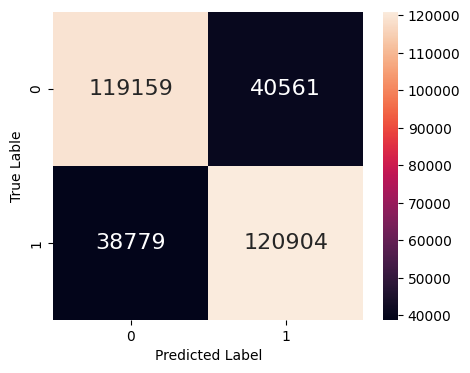

In [20]:
import matplotlib.pyplot as plt
import seaborn as sn
plt.figure(figsize=(5,4))
# cm_df = pd.DataFrame(cm, index = ['Negative','Positive'], columns = ['Negative','Positive'])
sn.heatmap(cm, annot=True, fmt='d', annot_kws={'size':16})
plt.xlabel("Predicted Label"); plt.ylabel('True Lable');

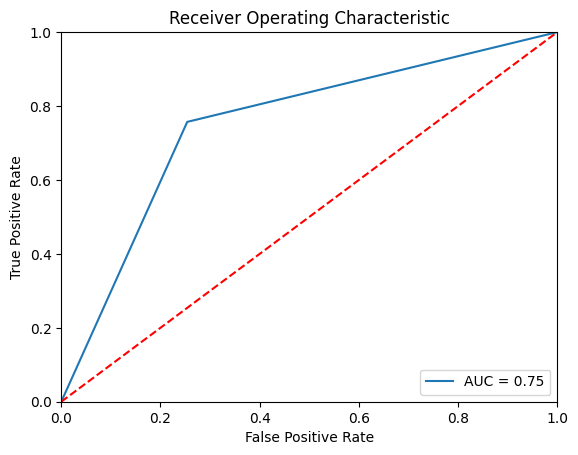

In [21]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Calculate FPR and TPR
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, label='AUC = %0.2f' % roc_auc)
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.show()

In [30]:
def plot_roc(test_data, predict_prob, model_name):
    from sklearn.metrics import auc, roc_curve
    fpr_neg, tpr_neg, thresholds_neg = roc_curve( 
              (test_data['polarity']==0).astype(np.float32), # is negative? 
             predict_prob[:,0] # prediction: probability of negative
    )
#     fpr_neu, tpr_neu, thresholds_neu = roc_curve( 
#               (test_data['airline_sentiment']=='neutral').astype(np.float32), # is neutral
#              predict_prob[:,1] # prediction: probability of neutral
#     )
    fpr_pos, tpr_pos, thresholds_pos = roc_curve( 
             (test_data['polarity']==1).astype(np.float32), # is positive
             predict_prob[:,1] # prediction: probability of positive
    )

    fig, ax = plt.subplots(figsize=(9,9))
    plt.plot(fpr_neg, fpr_neg, 'k:', label=None)
    plt.plot(fpr_neg, tpr_neg, label=f'negative. auc={auc(fpr_neg, tpr_neg):2.2f}')
#     plt.plot(fpr_neu, tpr_neu, label=f'neutral. auc={auc(fpr_neu, tpr_neu):2.2f}')
    plt.plot(fpr_pos, tpr_pos, label=f'positive. auc={auc(fpr_pos, tpr_pos):2.2f}')

    plt.legend(); plt.title(f'AUC: {model_name}')
    plt.xlabel('false-positive rate');plt.ylabel('true-positive rate');
    

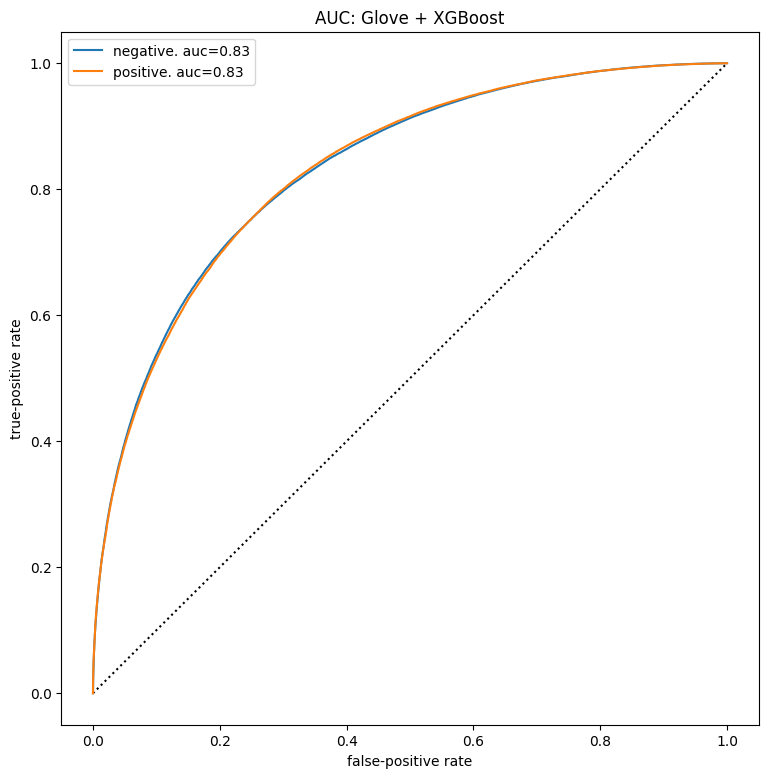

In [31]:
glove_xgboost_prob = glove_xgboost_model.predict_proba(test_glove_vectors)
plot_roc(test_data, predict_prob=glove_xgboost_prob, model_name='Glove + XGBoost')